การควบคุมเหมาะที่สุดและการเรียนรูู้เสริมกำลัง -- ดร.วโรดม ตู้จินดา

# 5A แนววิถีเหมาะที่สุดแบบไม่เป็นเชิงเส้น

เนื่องจากผู้เขียนได้ทดสอบการใช้ pytorch ในภายหลัง เพื่อมิให้โค้ดในสมุดบันทึกหลักของหนังสือมีความซับซ้อนเกินไป จึงรวบรวมตัวอย่างและโค้ดสำหรับกรณีที่ใช้ pytorch ไว้ในสมุดบันทึกเสริมนี้

**หมายเหตุ :** สรุปผลการทดสอบ พบว่าการใช้แพ็กเกจ pytorch มีความเร็วมากกว่า jax แต่ก็ไม่มากนัก โดยรวมความเร็วการประมวลผลยังด้อยกว่า drake อยู่มาก 

[กลับสู่บทที่ 5](chapter5.ipynb)

* [ตัวอย่าง 5.1](#ex5_1)
* [ตัวอย่าง 5.2](#ex5_2)

***

<a id="ex5_1"></a>

**ตัวอย่าง 5.1** 

หุ่นยนต์กายกรรม (acrobot) [1] เป็นชื่อเรียกแขนกลในระนาบที่มีตัวขับเคลื่อนอยู่ที่ข้อศอกเพียงตัวเดียวดังแสดงในรูปที่ 5.1 
ชื่อภาษาอังกฤษได้มาจากการเคลี่อนที่ที่คล้ายกับนักกายกรรมโหนบาร์คู่ (acrobat) ที่ใช้แรงจากสะโพกเพื่อเหวี่ยงตัวขึ้นสู่ตำแหน่งแนวดิ่งด้านบน 
และทรงตัวอยู่ในตำแหน่งนั้น เป็นตัวอย่างหนึ่งของระบบที่ถูกกระตุ้นไม่เต็มที่ (underactuated) 
และยังมีความสำคัญเพราะพลวัตมีความคล้ายกับโมเดลอย่างง่ายในการเดินของหุ่นยนต์

<img src="https://raw.githubusercontent.com/dewdotninja/ocrl/refs/heads/main/doc/figs/ch5_acrobot.png" width=700 />

รูปที่ 5.1 หุ่นยนต์กายกรรม

ในตัวอย่างนี้จะใช้วิธี DDP เพื่อหาแนววิถีเหมาะที่สุดของหุ่นยนต์กายกรรมจากตำแหน่งเริ่มต้น 
คือเมื่อแขนทั้งสองชี้ลงในแนวดิ่งอันเป็นจุดสมดุลที่เสถียร 
ไปยังตำแหน่งสุดท้ายคือแขนทั้งสองเหยียตตรงชี้ขึ้นในแนวดิ่ง 
ลักษณะเหมือนการทรงตัวของนักกายกรรมในตำแหน่งหัวกลับ 

นำเข้าไลบรารีที่ต้องการใช้ 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
# from torch.linalg import solve,eigvals, inv
from scipy.linalg import block_diag
from numpy import kron
import torch
from torch.func import jacfwd, hessian

เมื่อนิยามสถานะ $x = [\theta_1, \;\theta_2, \;\dot{\theta}_1, \;\dot{\theta}_2]$ และอินพุต 
$u$ เป็นค่าแรงบิดของข้อต่อ 2 พลวัตหุ่นยนต์สามารถเขียนเป็นฟังก์ชัน acrobot_dynamics() ได้ดังนี้ 


In [2]:
ad_flag = False  # set it to True to use gradient

In [3]:
# use numpy for rollout, torch for autodiff. 
def acrobot_dynamics(x,u):
    # global M_1,B_1,C_1,G_1,m11,m12,m22,thetaddot,b_ # debug
    # parameters
    g = 9.81
    m1 = m2 = 1.0
    l1 = l2 = 1.0
    J1 = J2 = 1.0
    theta1 = x[0]
    theta2 = x[1]
    theta1dot = x[2]
    theta2dot = x[3]   
    if ad_flag == False:
        s1 = np.sin(theta1)
        c1 = np.cos(theta1)
        s2 = np.sin(theta2)
        c2 = np.cos(theta2)
        c12 = np.cos(theta1+theta2)
    else:
        s1 = torch.sin(theta1)
        c1 = torch.cos(theta1)
        s2 = torch.sin(theta2)
        c2 = torch.cos(theta2)
        c12 = torch.cos(theta1+theta2)

    # mass matrix
    m11 = (m1*l1*l1 + J1 + m2*(l1*l1 + l2*l2 + 2*l1*l2*c2) + J2)
    m12 = (m2*(l2*l2 + l1*l2*c2 + J2))
    m22 = (l2*l2*m2 + J2)

    # bias term
    tmp = l1*l2*m2*s2
    b1 = -(2*theta1dot*theta2dot + theta2dot**2)*tmp
    b2 = tmp*theta1dot**2

    # friction
    c = 1.0

    # gravity term
    g1 = ((m1 + m2)*l2*c1 + m2*l2*c12) * g
    g2 = m2*l2*c12*g

    if ad_flag == False:
        M_1 = np.zeros((2,2))
        M_1[0,0] = m11.item()
        M_1[0,1] = m12.item()
        M_1[1,0] = m12.item()
        M_1[1,1] = m22

        B_1 = np.array([b1, b2]).reshape(2,1)

        C_1 = np.array([c*theta1dot, c*theta2dot]).reshape(2,1)
        
        G_1 = np.array([g1, g2]).reshape(2,1)
        tau = np.zeros((2,1))
        
        tau[1,0] = u
        b_ = tau - B_1 - G_1 - C_1

        thetaddot = np.linalg.solve(M_1,b_)
        y = np.zeros((4,1))
        y[0,0] = theta1dot.item()
        y[1,0] = theta2dot.item()
        y[2,0] = thetaddot[0].item()
        y[3,0] = thetaddot[1].item()        
    else:
        M_1 = torch.zeros(2,2)
        M_1[0,0] = m11
        M_1[0,1] = m12
        M_1[1,0] = m12
        M_1[1,1] = m22

        # warning: never use B_1 = torch.tensor([b1,b2]). That leads to incorrect gradient computation
        # that is very difficult to find. This applies to all tensors below.
        B_1 = torch.zeros(2,1)
        B_1[0,0] = b1
        B_1[1,0] = b2

        C_1 = torch.zeros(2,1)
        C_1[0,0] = c*theta1dot
        C_1[1,0] = c*theta2dot

        G_1 = torch.zeros(2,1)
        G_1[0,0] = g1
        G_1[1,0] = g2

        tau = torch.zeros(2,1)
        tau[1,0] = u
        b_ = (tau - B_1 - G_1 - C_1).to(torch.float32)

        thetaddot = torch.linalg.solve(M_1,b_)
        y = torch.zeros(4,1)
        y[0,0] = theta1dot
        y[1,0] = theta2dot
        y[2,0] = thetaddot[0]
        y[3,0] = thetaddot[1]
    return y

โดยวิธีการเหมือนที่ใช้ในบทที่ 4 สร้างฟังก์ชัน acrobot_dynamics_rk4() เพื่อคำนวณปริพันธ์โดยวิธีรุงเงอ คุททา (RK4) 
ใช้ร่วมกับการหาอนุพันธ์อัตโนมัติเพื่อประมาณค่าเชิงเส้นแบบดีสครีต 

In [4]:
def acrobot_dynamics_rk4(x,u):
    #RK4 integration with zero-order hold on u

    f1 = acrobot_dynamics(x, u)
    
    x_2 = x + 0.5*h*f1
    f2 = acrobot_dynamics(x_2, u)
    
    x_3 = x + 0.5*h*f2
    f3 = acrobot_dynamics(x_3, u)

    x_4 = x + 0.5*h*f3
    f4 = acrobot_dynamics(x_4, u)

    ft = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    
    return ft

สร้างฟังก์ชันหาอนุพันธ์อัตโนมัติเพื่อสะดวกในการเรียกใช้งาน รวมถึงฟังก์ชันสนับสนุนตามที่ได้อธิบายในภาคผนวก C1

In [5]:
# convert [m,n,p] tensor to [m*n,p] matrix
def tensor2mat(Mat3d):
    dim3 = Mat3d.shape[2]
    M = Mat3d[:,:,0]
    for i in range(dim3-1):
        M = torch.vstack([M,Mat3d[:,:,i+1]])
    return M

# vertical stack a matrix to column vector
def mat2colvec(mat):
    dim0 = mat.shape[0]
    dim1 = mat.shape[1]
    colvec = mat[:,[0]]
    for i in range(1,dim1):
        colvec = torch.vstack([colvec,mat[:,[i]]])
    return colvec


def dfdx(x,u):
    y = torch.squeeze(jacfwd(acrobot_dynamics_rk4,argnums=0)(x,u))
    return y

def dfdu(x,u):
    y = jacfwd(acrobot_dynamics_rk4,argnums=1)(x,u)
    return y

def dAdx(x,u):
    y = hessian(acrobot_dynamics_rk4)(x,u) # argnums=0 is default
    return torch.squeeze(tensor2mat(y)[:,0,:])

def dBdx(x,u):
    y = torch.squeeze(jacfwd(dfdu)(x,u))
    return y

def dAdu(x,u):
    y = jacfwd(dfdx,argnums=1)(x,u)
    yr = mat2colvec(y)
    return yr

def dBdu(x,u):
    y = jacfwd(dfdu,argnums=1)(x,u)
    return y


ทดสอบฟังก์ชันการหาอนุพันธ์ทั้งหมดเพื่อตรวจสอบความถูกต้อง ก่อนใช้งานในอัลกอริทึม

In [6]:
x0 = torch.tensor([-torch.pi/2,0,0,0],requires_grad=True).reshape(4,1)
u0 = torch.tensor(1.0,requires_grad=True)
h = 0.05

In [7]:
ad_flag = True
A = dfdx(x0,u0).detach().numpy()
print('A.shape = ',A.shape)
print('A = ')
print(A)

A.shape =  (4, 4)
A = 
[[ 9.9394691e-01  1.9558396e-03  4.9500454e-02  6.3749362e-04]
 [ 3.9414782e-03  9.9202102e-01  6.6768233e-04  4.8458096e-02]
 [-2.8885818e-01  9.2133634e-02  9.7452939e-01  3.0764157e-02]
 [ 1.8621956e-01 -3.7902462e-01  3.2749247e-02  9.2457938e-01]]


In [8]:
B = dfdu(x0,u0).detach().numpy()
print('B.shape = ',B.shape)
print('B = ')
print(B)

B.shape =  (4, 1)
B = 
[[-0.00060754]
 [ 0.00142085]
 [-0.02880777]
 [ 0.0674407 ]]


In [9]:
Ax = dAdx(x0,u0).detach().numpy()
print('Ax.shape = ',Ax.shape)
print('Ax = ')
print(Ax)

Ax.shape =  (16, 4)
Ax = 
[[-8.1004686e-07  1.0563144e-07 -3.3027064e-08  2.2263897e-09]
 [ 1.7156659e-06 -1.6562929e-06  9.4985204e-08 -3.9552415e-08]
 [-9.4428979e-05  8.9520308e-06 -3.8366875e-06  1.6965998e-07]
 [ 2.0010765e-04 -1.1888854e-04  1.1074984e-05 -2.7440574e-06]
 [ 1.0563169e-07  4.2962481e-04  6.2684971e-06  1.5729882e-05]
 [-1.6562925e-06 -9.3831029e-04 -3.4972749e-07 -2.7662170e-05]
 [ 8.9520499e-06  1.9963088e-02  4.1371002e-04  1.0174369e-03]
 [-1.1888855e-04 -4.3615945e-02 -2.9953571e-05 -1.7836291e-03]
 [-3.3027064e-08  6.2684953e-06  2.1887318e-07  3.0081389e-07]
 [ 9.4985211e-08 -3.4972163e-07 -5.0327907e-07 -2.2961916e-07]
 [-3.8366875e-06  4.1371005e-04  2.5522048e-05  2.7203068e-05]
 [ 1.1074983e-05 -2.9953526e-05 -5.8725989e-05 -2.6500313e-05]
 [ 2.2263922e-09  1.5729882e-05  3.0081389e-07  7.6313279e-07]
 [-3.9552418e-08 -2.7662172e-05 -2.2961922e-07 -1.2394681e-06]
 [ 1.6966004e-07  1.0174369e-03  2.7203067e-05  5.6329933e-05]
 [-2.7440581e-06 -1.7836292e-

In [10]:
Bx = dBdx(x0,u0).detach().numpy()
print('Bx.shape = ',Bx.shape)
print('Bx = ')
print(Bx)

Bx.shape =  (4, 4)
Bx = 
[[ 5.7024424e-10  3.2050721e-07  3.6520880e-09  1.3297638e-08]
 [-2.0439945e-09 -6.6594504e-07 -3.9655201e-10 -2.4384136e-08]
 [ 6.5003924e-08  2.4515775e-05  4.3023948e-07  1.2302501e-06]
 [-2.3614361e-07 -5.1315539e-05 -4.4854989e-08 -2.1820799e-06]]


In [11]:
Au = dAdu(x0,u0).detach().numpy()
print('Au.shape = ',Au.shape)
print('Au = ')
print(Au)

Au.shape =  (16, 1)
Au = 
[[ 7.0707479e-10]
 [-1.9184145e-09]
 [ 8.0882742e-08]
 [-2.2131930e-07]
 [ 3.9718734e-07]
 [-8.3282771e-07]
 [ 3.3460674e-05]
 [-7.0788148e-05]
 [ 3.6554386e-09]
 [-3.7883630e-10]
 [ 4.3081698e-07]
 [-4.3195975e-08]
 [ 1.5224080e-08]
 [-2.8576757e-08]
 [ 1.4545976e-06]
 [-2.6704745e-06]]


In [12]:
Bu = dBdu(x0,u0).detach().numpy()
print('Bu.shape = ',Bu.shape)
print('Bu = ')
print(Bu)

Bu.shape =  (4, 1)
Bu = 
[[ 3.4056202e-10]
 [-7.1388939e-10]
 [ 3.9461167e-08]
 [-8.2679719e-08]]


กำหนดค่าขั้นเวลา จำนวนสถานะ อินพุต เวลาปลาย จำนวนขั้นเวลา และเวกเตอร์สำหรับจุดค่าเวลา

In [13]:
h = 0.05  # time step
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 10.0 # final time 
Nt = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(Nt),h)

กำหนดค่าน้ำหนักสำหรับมูลค่าขั้นของสถานะและอินพุต และน้ำหนักของสถานะสุดท้ายซึ่งเราจะให้มีค่ามาก 
เพื่อให้ความสำคัญกับการลู่เข้าสู่ตำแหน่งเป้าหมาย

In [14]:
# Cost weights (changed to numpy)
Q = block_diag(1.0*np.eye(2), 0.1*np.eye(2))

R = 0.01
Qn = 100*np.eye(Nx) # large weight on terminal cost

สร้างฟังก์ชันคำนวณมูลค่า

In [15]:
def stage_cost(x,u):
    xbar = x-xgoal
    return 0.5*((xbar.T@Q@xbar) + R*u*u)

def terminal_cost(x):
    xbar = x-xgoal
    return 0.5*xbar.T@Qn@xbar

def cost(xtraj, utraj):
    J = 0.0
    for k in range(Nt-1):
        J += stage_cost(xtraj[:,[k]],utraj[k])
    J += terminal_cost(xtraj[:,[Nt-1]])
    return J.item()

กำหนดค่าสถานะเริ่มต้นเป็นตำแหน่งแขนห้อยลงแนวดิ่ง $\theta_1 = \pi /2, \theta_2 = 0$ และสถานะปลายคือตำแหน่งตั้งขึ้น 
$\theta_1 = -\pi /2, \theta_2 = 0$ ค่าแนววิถีสถานะกำหนดให้เท่ากับค่าสถานะเริ่มต้นทั้งหมด
ส่วนค่าแนววิถีตัวควบคุมเริ่มต้นให้เป็นค่าสุ่ม 

**หมายเหตุ :** หากกำหนดให้แนววิถีเริ่มต้นของตัวควบคุมเป็นศูนย์ทั้งหมด 
ความสมมาตรจะทำให้อัลกอริทึมไม่สามารถเริ่มต้นได้ เพราะตัดสินใจไม่ได้ว่าจะแกว่งแขนขึ้นทางซ้ายหรือขวา



In [16]:
x0 = np.array([-np.pi/2,0,0,0]).reshape(4,1)
xgoal = np.array([np.pi/2,0,0,0]).reshape(4,1)
xtraj = np.kron(np.ones((1,Nt)),x0)
utraj = np.random.rand(Nt-1)

คำนวณแผ่ไปข้างหน้าครั้งแรกโดยใช้ตัวควบคุมค่าสุ่ม และตรวจสอบมูลค่าเบื้องต้น

In [17]:
ad_flag = False
for k in range(Nt-1):
    xtraj[:,[k+1]] = acrobot_dynamics_rk4(xtraj[:,[k]], utraj[k])
J = cost(xtraj, utraj)
J

1507.9128553984924

**หมายเหตุ :** ตัวอย่าง 5.1 ในโน๊ตบุคเสริมนี้มีความแตกต่างจากตัวอย่างเดิมอยู่เล็กน้อย โดยเขียนแยกเป็นฟังก์ชันย่อยลักษณะเดียวกับตัวอย่าง 5.2 เพื่อให้มีความเป็นโครงสร้างมากขึ้น 
นอกจากนั้นยังสามารถรันได้ทั้งอัลกอริทึม DDP และ iLQR เนื่องจาก torch สนับสนุนการคำนวณ hessian 

ฟังก์ชันเสริมในเซลล์นี้ใช้สำหรับโหมด DDP

In [18]:
from scipy.sparse import csr_matrix
def comm(M):
    m, n = M.shape[0], M.shape[1]
    row  = np.arange(m*n)
    col  = row.reshape((m, n), order='F').ravel()
    data = np.ones(m*n, dtype=np.int8)
    T = csr_matrix((data, (row, col)), shape=(m*n, m*n))
    return T.toarray()

# this commutation matrix is constant. So just compute it once and use commA in the loop.
Amat = np.zeros((Nx,Nx))
commA = comm(Amat)

def is_pos_def(x): # check positive definite for regularization
    return np.all(np.linalg.eigvals(G)>0)


นิยามฟังก์ชันแผ่ไปข้างหน้าเริ่มต้น initial_rollout()

In [19]:
def initial_rollout():
    global xtraj
    for k in range(Nt-1):
        xtraj[:,[k+1]] = acrobot_dynamics_rk4(xtraj[:,[k]], utraj[k])
    J = cost(xtraj, utraj)
    return J   

ฟังก์ชันคำนวณย้อนหลัง backward_pass() โดยมีอาร์กิวเมนต์สำหรับเลือกโหมด mode='ilqr' 
หรือ mode='ddp' ค่าโดยปริยายคือ 'ilqr' 

In [20]:
def backward_pass(mode='ilqr'):
    global ad_flag,p,P,d,K,gx,gu,Gxx,Gxu,Gux,Guu,G, k,A,B,Ax,Bx,Au,Bu,x_k,u_k,xk_grad, uk_grad,q,r
    dJ = 0.0
    p[:,[Nt-1]] = Qn@(xtraj[:,[Nt-1]]-xgoal)
    P[:,:,Nt-1] = Qn
    
    for k in range(Nt-2,-1,-1):
        x_k = xtraj[:,[k]]
        u_k = utraj[k]
        # Calculate derivatives
        q  = Q@(x_k - xgoal)
        r = R*u_k
        ad_flag = True
        xk_grad = torch.tensor(x_k,requires_grad=True)
        uk_grad = torch.tensor(u_k,requires_grad=True) 
        A = dfdx(xk_grad,uk_grad).detach().numpy()
        B = dfdu(xk_grad,uk_grad).detach().numpy()

        gx = q + A.T@p[:,[k+1]]
        gu = r + B.T@p[:,[k+1]]

        if mode=='ddp': # DDP (full Newton) version
            # compute autodiff by torch 
            ad_flag = True
            Ax = dAdx(xk_grad,uk_grad).detach().numpy()
            Bx = dBdx(xk_grad,uk_grad).detach().numpy()
            Au = dAdu(xk_grad,uk_grad).detach().numpy()
            Bu = dBdu(xk_grad,uk_grad).detach().numpy()
            Gxx = (Q + A.T@P[:,:,k+1]@A + 
                    np.kron(p[:,[k+1]].T,np.eye(Nx))@commA@Ax)
            Guu = (R + B.T@P[:,:,k+1]@B + 
                    (np.kron(p[:,[k+1]].T, np.eye(Nu))@Bu)[0])
            Gxu = (A.T@P[:,:,k+1]@B + 
                    np.kron(p[:,[k+1]].T,np.eye(Nx))@commA@Au)
            Gux = (B.T@P[:,:,k+1]@A + 
                    np.kron(p[:,[k+1]].T, np.eye(Nu))@Bu)
                
            beta = 0.1
            G = np.block([[Gxx, Gxu],[Gux, Guu]])
            while not is_pos_def(G):
                Gxx += beta*np.eye(Gxx.shape[0])
                Guu += beta*np.eye(Guu.shape[0])
                G = np.block([[Gxx, Gxu],[Gux, Guu]])
                beta = 2*beta
                print("regularizing G, beta = "+str(beta),end="\r")
        else:  # default to ilqr mode
            # iLQR (Gauss-Newton) version 
            Gxx = Q + A.T@P[:,:,k+1]@A
            Guu = R + B.T@P[:,:,k+1]@B
            Gxu = A.T@P[:,:,k+1]@B
            Gux = B.T@P[:,:,k+1]@A
            

        d[k] = np.linalg.solve(Guu,gu).item()
        K[:,:,k] = np.linalg.solve(Guu,Gux)

        p[:,[k]] = gx - K[:,:,k].T@gu + K[:,:,k].T@Guu*d[k] - Gxu*d[k]
        P[:,:,k] = Gxx + K[:,:,k].T@Guu@K[:,:,k] - Gxu@K[:,:,k] - K[:,:,k].T@Gux

        dJ += (gu.T*d[k]).item()
    return dJ

นิยามฟังก์ชันแผ่ไปข้างหน้าโดยมีการค้นหาตามเส้น rollout_with_ls()

In [21]:
def rollout_with_ls():
    global ad_flag,xtraj, xn, un, Jn, alpha
    xn[:,[0]] = xtraj[:,[0]]
    alpha = 1.0
    for k in range(Nt-1):
        un[k] = (utraj[k] - alpha*d[k] - K[:,:,k]@(xn[:,[k]]-xtraj[:,[k]])).item()
        ad_flag = False
        xn[:,[k+1]] = acrobot_dynamics_rk4(xn[:,[k]],un[k])

    Jn = cost(xn,un)
    
    while np.isnan(Jn) or Jn > (J - (1e-2)*alpha*dJ):
        alpha = 0.5*alpha
        # print("alpha = "+str(alpha))
        for k in range(Nt-1):
            un[k] = (utraj[k] - alpha*d[k] - K[:,:,k]@(xn[:,[k]]-xtraj[:,[k]])).item()
            xn[:,[k+1]] = acrobot_dynamics_rk4(xn[:,[k]],un[k])
        Jn = cost(xn,un)    

เมื่อนิยามฟังก์ชันย่อยทั้งหมดแล้ว ประกอบกันเป็นฟังก์ชัน ddp() สำหรับอัลกอริทึม DDP  
การเลือกโหมดทำได้โดยใส่อาร์กิวเมนต์ดังนี้ 

```python
ddp() # default to iLQR mode
ddp('ilqr') # iLQR mode
ddp('ddp') # DDP mode
```

In [22]:
# DDP algorithm
def ddp(mode='ilqr'):
    global p,P,d,K,dJ,xtraj,utraj, gx, gu, Gxx, Guu, Gxu, Gux, iter, J, Jn, xn, un
    p = np.zeros((Nx,Nt))
    P = np.zeros((Nx, Nx, Nt))
    d = np.ones((Nt-1))
    K = np.zeros((Nu, Nx, Nt-1))
    dJ = 0.0
    
    xn = np.zeros((Nx,Nt))
    un = np.zeros((Nt-1))

    gx = np.zeros((Nx))
    gu = 0.0
    Gxx = np.zeros((Nx,Nx))
    Guu = 0.0
    Gxu = np.zeros((Nx))
    Gux = np.zeros((Nx))
    
    iter = 0
    while np.max(abs(d)) >2e-2 and iter<3000:
        iter+=1
    
        # Backward pass
        dJ = backward_pass(mode)  
            
        # forward rollout with line search
        rollout_with_ls()
            
        # logging. 
        # Print every iteration 
        if (iter-1)%10 == 0:  # print heading every 10 iterations
            print("iter        J                  ΔJ                   |d|             α       ")
            print("-----------------------------------------------------------------------------")
        if (iter-1)%1 == 0: # print values every 1 iterations
            print("{}   {}    {}   {}    {} ".format(iter, J,
                                        dJ, np.max(abs(d)), alpha))
        # Print every 10 iterations
        # if (iter-1)%100 == 0:  # print heading every 100 iterations
        #     print("iter        J                  ΔJ                   |d|             α       ")
        #     print("-----------------------------------------------------------------------------")
        # if (iter-1)%10 == 0: # print values every 10 iterations
        #     print("{}   {}    {}   {}    {} ".format(iter, J,
        #                                 dJ, np.max(abs(d)), alpha))
            
        J = Jn
        xtraj = xn.copy()
        utraj = un.copy()                   


เราได้กำหนดค่าเริ่มต้นแล้วในเซลล์ด้านบน คัดลอกมาอีกครั้งหนึ่งเพื่อความสะดวก

In [26]:
x0 = np.array([-np.pi/2,0,0,0]).reshape(4,1)
xgoal = np.array([np.pi/2,0,0,0]).reshape(4,1)
xtraj = np.kron(np.ones((1,Nt)),x0)
utraj = np.random.rand(Nt-1)

คำนวณมูลค่าเริ่มต้น

In [27]:
ad_flag = False
J = initial_rollout()
J

1510.607706324004

ทดสอบอัลกอริทึมโดยรันเซลล์ด้านล่างนี้

In [28]:
ddp() # iLQR mode
# ddp('ddp') # DDP mode

iter        J                  ΔJ                   |d|             α       
-----------------------------------------------------------------------------
1   1510.607706324004    490.2926644700544   45.377712072089714    1.0 
2   1264.134316504603    89.5562864294133   22.815732028546428    1.0 
3   1228.1143933379108    28.718123905976412   9.954395041743977    1.0 
4   1221.3637477604693    29.799060757790325   13.834871478670063    0.5 
5   1214.5493490274496    2.397665543713197   3.4026596271113867    1.0 
6   1213.1906114076774    1.7299640156690441   2.84040083247121    1.0 
7   1212.8695778191745    2.3491737147655476   3.847930269852823    0.5 
8   1212.3477154879333    0.30072817787068107   1.0808066801018852    1.0 
9   1212.2245337126112    0.3387108649650888   1.3693261098740046    1.0 
10   1212.219620050801    0.6243827026524891   2.160756464241247    0.5 
iter        J                  ΔJ                   |d|             α       
--------------------------------------

การรันอัลกอริทึมจะใช้เวลานาน หากต้องการบันทึกและโหลดเวกเตอร์แนววิถีหลังจากสิ้นสุด ใช้คำสั่งดังเซลล์ด้านล่างนี้

In [ ]:
# np.savez('torch_acrobot_ddp_ilqr.npz',thist=thist,xtraj=xtraj,utraj=utraj)

In [ ]:
# npzfile = np.load('torch_acrobot_ilqr.npz')
# npzfile['thist']
# npzfile['xtraj']
# npzfile['utraj']

สร้างฟังก์ชันเพื่อแสดงแนววิถีเหมาะที่สุดของสถานะและตัวควบคุม ได้ผลดังแสดงในรูปที่ 5.2 และ 5.3 

In [29]:
def plot_x():
    plt.figure()
    plt.plot(thist,xtraj[0,:],"b-",thist,xtraj[1,:],'orange')
    plt.xlabel("time (sec)")
    plt.ylabel("x(k)")
    plt.legend(["theta1","theata2"])
    plt.grid(True)
    plt.show()

def plot_u():
    plt.plot(thist[0:Nt-1],utraj,"m-")
    plt.xlabel("time (sec)")
    plt.ylabel("u(k)")
    plt.grid(True)
    plt.show()

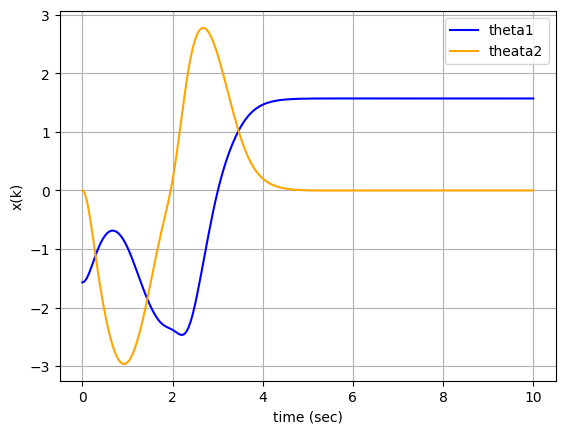

In [30]:
plot_x()

รูปที่ 5.2 แนววิถีเหมาะที่สุดของสถานะ $\theta_1$ และ $\theta_2$

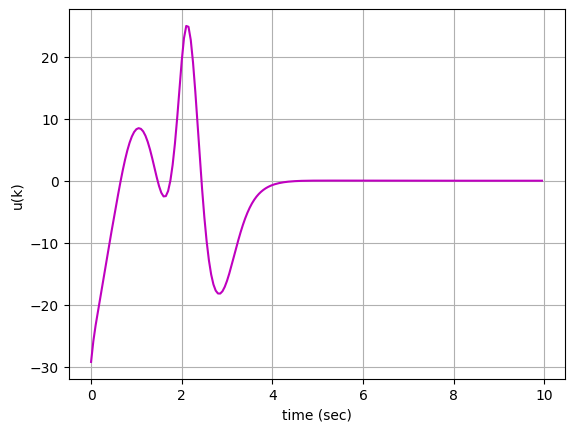

In [31]:
plot_u()

รูปที่ 5.3 แนววิถีเหมาะที่สุดของตัวควบคุม $u$ 

รันโค้ดในเซลล์ด้านล่างนี้ทั้งหมดเพื่อจำลองการเคลื่อนที่ของหุ่นยนต์กายกรรมโดย meshcat 
ดังเช่นในรูปที่ 5.4

<img src="https://raw.githubusercontent.com/dewdotninja/ocrl/refs/heads/main/doc/figs/ch5_acrobot_meshcat.png" width=400 />

รูปที่ 5.4 การจำลองหุ่นยนต์กายกรรมบน meshcat

(หากยังไม่ได้ติดตั้งต้องใช้คำสั่ง !pip install meshcat) 
ผลการจำลองจะมีลักษณะดังแสดงใน [วีดีโอนี้](https://youtu.be/qkP1aVt2a-8)

In [32]:
import meshcat
import meshcat.geometry as geo
import meshcat.transformations as tf    
import time

In [33]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [35]:
thick = 0.05
l1 = 1.0
l2 = 1.0

def build_acrobot(vis):
    acrobot = vis["acrobot"]
    base = acrobot["base"]
    pivot1 = acrobot["pivot1"]
    link1 = pivot1["link1"]
    pivot2 = link1["pivot2"]
    hinge = link1["hinge"]
    link2 = pivot2["link2"]
    base.set_object(geo.Sphere(thick))
    link1.set_object(geo.Box([l1,thick,thick]))
    link1.set_transform(tf.translation_matrix([-l1/2,0,0]))
    pivot2.set_transform(tf.translation_matrix([-l1/2,0,0]))
    link2.set_object(geo.Box([l2,thick,thick]))
    link2.set_transform(tf.translation_matrix([-l1/2,0,0]))
    hinge.set_object(geo.Sphere(thick))
    hinge.set_transform(tf.translation_matrix([-l1/2,0,0]))

    return pivot1, pivot2

# update acrobot pose
def update_acrobot(pivot1,pivot2,th1,th2):
    pivot1.set_transform(tf.rotation_matrix(th1,[0,1,0]))
    pivot2.set_transform(tf.translation_matrix([-l1/2,0,0]).dot(tf.rotation_matrix(th2,[0,1,0])))

def simulate_acrobot():
    for k in range(xtraj.shape[1]):
        th1 = xtraj[0,k]
        th2 = xtraj[1,k]
        update_acrobot(pv1,pv2,th1,th2)
        time.sleep(h)

In [36]:
pv1,pv2 = build_acrobot(vis)
update_acrobot(pv1,pv2,-np.pi/2,0)

In [38]:
simulate_acrobot()

***
<a id="ex5_2"></a>
**ตัวอย่าง 5.2** 

ทดลองใช้อัลกอริทึม DDP/iLQR หาแนววิถีเหมาะที่สุดของคาร์ทโพลดังในรูปที่ 5.5
ในตัวอย่าง C.7 ภาคผนวก C ได้อธิบายพลวัตโดยสังเขป ในตัวอย่างนี้จะกำหนดพารามิเตอร์ให้สอดคล้องกับ [3] 

<div align="center">
<img src="https://raw.githubusercontent.com/dewdotninja/sharing-github/master/cart_pole.png" width=500 />
</div>
<div align="center">รูปที่ 5.5 ระบบคาร์ทโพลในระนาบ 2 มิติ</div>

นิยามตัวแปรชื่อ use_torch สำหรับเลือกแพ็กเกจการหาอนุพันธ์อัตโนมัติ โดยตั้งค่าเป็น False หรือ True 
เมื่อต้องการใช้ Drake หรือ torch ตามลำดับ

In [39]:
use_torch = True

หลังจากตั้งค่าตัวแปร use_torch แล้วสามารถรันเซลล์ด้านล่างได้ทั้งหมด 
โดยในฟังก์ชันที่เกี่ยวข้องกับการหาอนุพันธ์อัตโนมัติจะมีเงื่อนไขที่ปรับโค้ดให้เหมาะสมสำหรับการใช้แพ็กเกจนั้น 
ตัวอย่างเช่นการเลือกใช้ numpy หรือ torch.tensor หรือการเลือก/ไม่เลือกโค้ดที่เรียกแพ็กเกจ PyTorch/Drake

แนวทางการเลือกใช้งาน 

* Drake จะคำนวณอนุพันธ์อัตโนมัติได้เร็วกว่า torch 
แต่มีข้อจำกัดคือไม่สามารถคำนวณเฮสเชียนได้โดยใช้ฟังก์ชันที่มากับแพ็กเกจ 
ดังนั้นหากต้องการใช้วิธี DDP เราใช้วิธีการคำนวณเฮสเซียนเชิงสัญลักษณ์โดยแพ็กเกจเสริม SymPy 
ซึ่งรายละเอียดทั้งหมดได้รวบรวมไว้ในภาคผนวก C

* torch เขียนโค้ดง่ายกว่า ในฟังก์ชันที่มีการคำนวณอนุพันธ์ต้องใช้ torch แทน numpy 
และต้องตั้งอาร์กิวเมนต์ requires_grad=True นอกจากนั้นการคำนวณอนุพันธ์อัตโนมัติใช้เวลามาก 
จึงต้องการคอมพิวเตอร์ที่สมรรถนะสูง ข้อดีอีกประการคือสามารถคำนวณเฮสเซียนได้ 
ดังนั้นจึงใช้ได้กับทั้งวิธี iLQR และ DDP 

นำเข้าแพ็กเกจทั้งหมดที่ต้องการใช้

In [40]:
import numpy as np 
from numpy import kron
import matplotlib.pyplot as plt 
from scipy.linalg import block_diag
import torch
from torch.func import jacfwd, jacrev, hessian
from hessian_symbolic.cartpole_hessian import cartpole_hessian_rk4, symbols, sin, cos, Array, diff, simplify, lambdify
from pydrake import forwarddiff
from pydrake.autodiffutils import AutoDiffXd, ExtractGradient, ExtractValue, InitializeAutoDiff    

และเนื่องจากการใช้ torch.tensor จะประมวลผลช้ากว่า numpy เราจึงเพิ่มตัวแปรส่วนกลาง ad_flag 
เพื่อใช้ torch.tensor เฉพาะในกรณีคำนวณอนุพันธ์อัตโนมัติเท่านั้น โดยตั้ง ad_flag = True 
แต่ในกรณีคำนวณเอาต์พุตของฟังก์ชันปกติจะตั้งค่า ad_flag = False 

**หมายเหตุ :** วิธีการนี้จะเห็นผลชัดเจนในทิศทางการแผ่ไปข้างหน้าเมื่อใช้ numpy แทน torch.tensor 
แต่เนื่องจากการคำนวณอนุพันธ์ในทิศทางย้อนหลังจะใช้เวลานานกว่ามาก 
ดังนั้นโดยรวมจะพบว่าอัลกอริทึมจะยังคงใช้เวลานานเมื่อใช้ torch

In [41]:
ad_flag = False

นิยามค่าขั้นเวลา จำนวนสถานะและตัวควบคุม เวลาปลาย จำนวนขั้น และเวกเตอร์ขั้นเวลา เหมือนในตัวอย่างอื่นก่อนหน้านี้

In [42]:
h = 0.05  # time step. Defined above
Nx = 4     # number of state
Nu = 1     # number of controls
Tfinal = 5.0 # final time 
Nt = int(Tfinal/h)+1    # number of time steps
thist = np.arange(0,h*(Nt-1),h)

นิยามเมทริกซ์น้ำหนักสำหรับมูลค่า ฟังก์ชันคำนวณมูลค่าขั้น มูลค่าปลาย และมูลค่ารวม

In [43]:
# Cost weights
Q = block_diag(1.0*np.eye(2), 1.0*np.eye(2))
R = 0.1
Qn = 100*np.eye(Nx) # large weight on terminal cost

def stage_cost(x,u):
    xbar = x-xgoal
    return 0.5*((xbar.T@Q@xbar) + R*u*u)    

def terminal_cost(x):
    xbar = x-xgoal
    return 0.5*xbar.T@Qn@xbar

def cost(xtraj, utraj):
    J = 0.0
    for k in range(Nt-1):
        J += stage_cost(xtraj[:,[k]],utraj[k])
    J += terminal_cost(xtraj[:,[Nt-1]])
    return J.item()

ฟังก์ชันคำนวณพลวัตของคาร์ทโพล และฟังก์ชันหาปริพันธ์วิธีรุงเงอ คุตตา (RK4) 

In [44]:
def cartpole(x, u):
    global y1,y2,y3,y4
    # parameters. Changed to match RobotZoo's cartpole
    m_c = 1.0  # cart mass
    m_p = 0.2 # pendulum mass
    l = 0.5  # pole length
    g = 9.81  # gravity

    if use_torch and ad_flag:
        c = torch.cos(x[1])  # cos(theta)
        s = torch.sin(x[1])  # sin(theta)
        y = torch.zeros(4,1)
        y[0,0] = x[2]  # x_dot is the 3rd element of state vector
        y[1,0] = x[3]  # theta_dot is the 4th element of state vector
        y[2,0] = (1/(m_c + m_p*s**2))*(u + m_p*s*(l*x[3]**2+g*c))  # from (16) of [3]
        y[3,0] = (1/(l*(m_c + m_p*s**2)))*(-u*c - m_p*l*x[3]**2*c*s - (m_c+m_p)*g*s)  # from (17) of [3]         
    else:
        c = np.cos(x[1])  # cos(theta)
        s = np.sin(x[1])  # sin(theta)    
        y1 = x[2]  # x_dot is the 3rd element of state vector
        y2 = x[3]  # theta_dot is the 4th element of state vector
        y3 = (1/(m_c + m_p*s**2))*(u + m_p*s*(l*x[3]**2+g*c))
        y4 = (1/(l*(m_c + m_p*s**2)))*(-u*c - m_p*l*x[3]**2*c*s - (m_c+m_p)*g*s)
        y = np.array([y1, y2, y3, y4]).reshape(4,1)
    return y

In [45]:
def cartpole_rk4(x,u):

    if use_torch == False:
        #RK4 integration with zero-order hold on u
        x_1 = x
        f1 = cartpole(x, u)
        
        x_a = x.reshape(4,1)
        x_2 = x_a + 0.5*h*f1
        f2 = cartpole(x_2.flatten(), u)
        
        x_3 = x_a + 0.5*h*f2
        f3 = cartpole(x_3.flatten(), u)

        x_4 = x_a + 0.5*h*f3
        f4 = cartpole(x_4.flatten(), u)

        ft = x_a + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    else:
        f1 = cartpole(x, u)
    
        x_2 = x + 0.5*h*f1
        f2 = cartpole(x_2, u)
        
        x_3 = x + 0.5*h*f2
        f3 = cartpole(x_3, u)

        x_4 = x + 0.5*h*f3
        f4 = cartpole(x_4, u)

        ft = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)        
    return ft

ฟังก์ชันในเซลล์ด้านล่างนี้เฉพาะสำหรับกรณีใช้ Drake (use_torch = False) 
คือการหาค่าอนุพันธ์ของฟังก์ชันที่อินพุตเป็นสเกลาร์และเอาต์พุตเป็นเวกเตอร์ เหมือนกับที่ใช้ในตัวอย่าง 5.1

In [46]:
def vecout_derivative(function, x):
    """Compute the derivative of the function evaluated at the scalar input x
    using Eigen's automatic differentiation.

    The function should be scalar-input and vector-output.
    """
    x_ad = AutoDiffXd(value=x, size=1, offset=0)
    y_ad = function(x_ad)
    y_derivative = ExtractGradient(y_ad)
    return y_derivative


ฟังก์ชันสำหรับคำนวณอนุพันธ์อัตโนมัติ โค้ดภายในถูกปรับให้ใช้งานได้ตามการตั้งค่า use_torch

In [47]:
def dfdx(x,u):
    global u_global
    u_global = u
    if use_torch:
        y = torch.squeeze(jacfwd(cartpole_rk4,argnums=0)(x,u))
    else:
        y = np.squeeze(forwarddiff.jacobian(cartpole_rk4_x,x.flatten()))
    return y

def dfdu(x,u):
    global x_global
    x_global = x
    if use_torch:
        y = jacfwd(cartpole_rk4,argnums=1)(x,u)
    else:
        y = vecout_derivative(cartpole_rk4_u,u)    
    return y

# wrapper functions for Drake (use_torch = False)
def cartpole_rk4_x(x):
    # global u_global 
    return cartpole_rk4(x, u_global)

def cartpole_rk4_u(u):
    # global x_global 
    return cartpole_rk4(x_global.flatten(), u)    

นิยามฟังก์ชันเสริมสำหรับกรณี DDP โดยใช้ torch ฟังก์ชันเหล่านี้จะไม่ถูกเรียกหาก use_torch = False 


In [48]:
# for DDP. use_torch=True
# convert [m,n,p] tensor to [m*n,p] matrix
def tensor2mat(Mat3d):
    dim3 = Mat3d.shape[2]
    M = Mat3d[:,:,0]
    for i in range(dim3-1):
        M = torch.vstack([M,Mat3d[:,:,i+1]])
    return M

# vertical stack a matrix to column vector
def mat2colvec(mat):
    dim0 = mat.shape[0]
    dim1 = mat.shape[1]
    colvec = mat[:,[0]]
    for i in range(1,dim1):
        colvec = torch.vstack([colvec,mat[:,[i]]])
    return colvec

from scipy.sparse import csr_matrix
def comm(M):
    m, n = M.shape[0], M.shape[1]
    row  = np.arange(m*n)
    col  = row.reshape((m, n), order='F').ravel()
    data = np.ones(m*n, dtype=np.int8)
    T = csr_matrix((data, (row, col)), shape=(m*n, m*n))
    return T.toarray()

# this commutation matrix is constant. So just compute it once and use commA in the loop.
Amat = np.zeros((Nx,Nx))
commA = comm(Amat)

def is_pos_def(x): # check positive definite for regularization
    return np.all(np.linalg.eigvals(x) > 0)

# for DDP, to compute last term of (5.15) - (5.17)
def dAdx(x,u):
    y = hessian(cartpole_rk4)(x,u)
    return torch.squeeze(tensor2mat(y)[:,0,:])

def dBdx(x,u):
    y = torch.squeeze(jacfwd(dfdu)(x,u))
    return y

def dAdu(x,u):
    y = jacfwd(dfdx,argnums=1)(x,u)
    return mat2colvec(y)

def dBdu(x,u):
    y = jacfwd(dfdu,argnums=1)(x,u)
    return y

สำหรับกรณีต้องการใช้วิธี DDP เมื่อ use_torch = False 
เราจะคำนวณพจน์เฮสเซียนเชิงสัญลักษณ์ตามวิธีการที่อธิบายในภาคผนวก C 
เพื่อความกระชับเราจะรวมโค้ดทั้งหมดในไฟล์ cartpole_hessian.py ที่จัดเก็บในไดเรคทอรีย่อย 
/hessian_symbolic/ ดังนั้นหากท่านรันโน๊ตบุกนี้ในเครื่องคอมพิวเตอร์ของตนเอง 
ต้องดาวน์โหลด /hessian_symbolic/cartpole_hessian.py ไปพร้อมกันด้วย 
และนำเข้าโดยคำสั่งที่ใส่ไว้ด้านบนแล้วคือ

```python
from hessian_symbolic.cartpole_hessian import symbols,sin,cos,Array,diff,simplify,lambdify
```
**ข้อควรระวัง :** ในแพ็กเกจ SymPy มีตัวแปร Q ที่ไปชนกับฟังก์ชันการคำนวณมูลค่า 
หลีกเลี่ยงการใช้คำสั่งดังนี้

```python
from hessian_symbolic.cartpole_hessian import *
```


นิยามฟังก์ชันแผ่ไปข้างหน้าเริ่มต้น initial_rollout()

In [49]:
def initial_rollout():
    global xtraj, ad_flag
    ad_flag = False
    for k in range(Nt-1):
        xtraj[:,[k+1]] = cartpole_rk4(xtraj[:,[k]], utraj[k])
    J = cost(xtraj, utraj)
    return J   

ฟังก์ชันคำนวณย้อนหลัง backward_pass() โดยมีอาร์กิวเมนต์สำหรับเลือกโหมด mode='ilqr' 
หรือ mode='ddp' ค่าโดยปริยายคือ 'ilqr' 
กรณี mode='ddp' หาก use_torch=True จะคำนวณพจน์เฮสเซียนโดยใช้ฟังก์ชันของ torch ที่นิยามด้านบน 
แต่หาก use_torch=False จะคำนวณพจน์เฮสเซียนเชิงสัญลักษณ์จากฟังก์ชันในไฟล์ cartpole_hessian.py

In [50]:
def backward_pass(mode='ilqr'):
       global ad_flag,p,P,d,K,gx,gu,Gxx,Gxu,Gux,Guu,G, k,A,B,Ax,Bx,Au,Bu,x_k,u_k,xk_grad, uk_grad,q,r
       dJ = 0.0
       p[:,[Nt-1]] = Qn@(xtraj[:,[Nt-1]]-xgoal)
       P[:,:,Nt-1] = Qn

       for k in range(Nt-2,-1,-1):
              x_k = xtraj[:,[k]]
              u_k = utraj[k]
              
              # Calculate derivatives
              q  = Q@(x_k - xgoal)
              r = R*u_k
              ad_flag = True
              if use_torch:
                  xk_grad = torch.tensor(x_k,requires_grad=True)
                  uk_grad = torch.tensor(u_k,requires_grad=True)
                
                  A = dfdx(xk_grad,uk_grad).detach().numpy()
                  B = dfdu(xk_grad,uk_grad).detach().numpy()
              else:
                  A = dfdx(xtraj[:,[k]], utraj[k])
                  B = dfdu(xtraj[:,[k]], utraj[k])

              gx = q + A.T@p[:,[k+1]]
              gu = r + B.T@p[:,[k+1]]


              if mode=='ddp': # DDP (full Newton) version
                  if use_torch:
                         # compute autodiff by torch
                         ad_flag = True
                         Ax = dAdx(xk_grad,uk_grad).detach().numpy()
                         Bx = dBdx(xk_grad,uk_grad).detach().numpy()
                         Au = dAdu(xk_grad,uk_grad).detach().numpy()
                         Bu = dBdu(xk_grad,uk_grad).detach().numpy()
                         Gxx = (Q + A.T@P[:,:,k+1]@A + 
                                np.kron(p[:,[k+1]].T,np.eye(Nx))@commA@Ax)
                         Guu = (R + B.T@P[:,:,k+1]@B + 
                                (np.kron(p[:,[k+1]].T, np.eye(Nu))@Bu)[0])
                         Gxu = (A.T@P[:,:,k+1]@B + 
                                np.kron(p[:,[k+1]].T,np.eye(Nx))@commA@Au)
                         Gux = (B.T@P[:,:,k+1]@A + 
                                np.kron(p[:,[k+1]].T, np.eye(Nu))@Bu)
                  else:
                         Ax = cartpole_hessian_rk4(xtraj[:,k],utraj[k],s='dadx')
                         Bx = cartpole_hessian_rk4(xtraj[:,k],utraj[k],s='dbdx')
                         Au = cartpole_hessian_rk4(xtraj[:,k],utraj[k],s='dadu')
                         Bu = np.zeros((4,1)) # Bu always zero.No need to compute
                         # Bu = cartpole_hessian_rk4(xtraj[:,k],utraj[k],s='dbdu')
                         Gxx = (Q + A.T@P[:,:,k+1]@A + 
                                kron(p[:,[k+1]].T,np.eye(Nx))@commA@Ax)
                         Guu = (R + B.T@P[:,:,k+1]@B + 
                                (kron(p[:,[k+1]].T, np.eye(Nu))@Bu)[0])
                         Gxu = (A.T@P[:,:,k+1]@B + 
                                kron(p[:,[k+1]].T,np.eye(Nx))@commA@Au)
                         Gux = (B.T@P[:,:,k+1]@A + 
                                kron(p[:,[k+1]].T, np.eye(Nu))@Bu)
                         
                  beta = 0.1
                  G = np.block([[Gxx, Gxu],[Gux, Guu]])
                  while not is_pos_def(G):
                         Gxx += beta*np.eye(Gxx.shape[0])
                         Guu += beta*np.eye(Guu.shape[0])
                         G = np.block([[Gxx, Gxu],[Gux, Guu]])
                         beta = 2*beta
                         print("regularizing G, beta = "+str(beta),end="\r")
              else:  # default to ilqr mode
                  # iLQR (Gauss-Newton) version 
                  Gxx = Q + A.T@P[:,:,k+1]@A
                  Guu = R + B.T@P[:,:,k+1]@B
                  Gxu = A.T@P[:,:,k+1]@B
                  Gux = B.T@P[:,:,k+1]@A
              
              if use_torch:
                     d[k] = np.linalg.solve(Guu,gu).item()
                     K[:,:,k] = np.linalg.solve(Guu,Gux)
              else:
                     d[k] = (gu/Guu).item()  # solve() has problem with SymPy object
                     K[:,:,k] = Gux/(Guu.item())
              

              p[:,[k]] = gx - K[:,:,k].T@gu + K[:,:,k].T@Guu*d[k] - Gxu*d[k]
              P[:,:,k] = Gxx + K[:,:,k].T@Guu@K[:,:,k] - Gxu@K[:,:,k] - K[:,:,k].T@Gux

              dJ += (gu.T*d[k]).item()
       return dJ

สุดท้ายคือนิยามฟังก์ชันแผ่ไปข้างหน้าโดยมีการค้นหาตามเส้น rollout_with_ls()

In [51]:
def rollout_with_ls():
    global ad_flag,xtraj, xn, un, Jn, alpha
    xn[:,[0]] = xtraj[:,[0]]
    alpha = 1.0
    for k in range(Nt-1):
        un[k] = (utraj[k] - alpha*d[k] - K[:,:,k]@(xn[:,[k]]-xtraj[:,[k]])).item()
        ad_flag = False
        xn[:,[k+1]] = cartpole_rk4(xn[:,[k]],un[k])

    Jn = cost(xn,un)
    
    while np.isnan(Jn) or Jn > (J - (1e-2)*alpha*dJ):
        alpha = 0.5*alpha
        # print("alpha = "+str(alpha))
        for k in range(Nt-1):
            un[k] = (utraj[k] - alpha*d[k] - K[:,:,k]@(xn[:,[k]]-xtraj[:,[k]])).item()
            xn[:,[k+1]] = cartpole_rk4(xn[:,[k]],un[k])
        Jn = cost(xn,un)    

เมื่อนิยามฟังก์ชันย่อยทั้งหมดแล้ว ประกอบกันเป็นฟังก์ชัน ddp() สำหรับอัลกอริทึม DDP  
การเลือกโหมดทำได้โดยใส่อาร์กิวเมนต์ดังนี้ 

```python
ddp() # default to iLQR mode
ddp('ilqr') # iLQR mode
ddp('ddp') # DDP mode
```
โดยเอาต์พุตของเซลล์จะแสดงค่าอัพเดตทุกรอบสำหรับการใช้ torch และทุก 10 รอบสำหรับ Drake 
ทั้งนี้เนื่องจากความเร็วที่ต่างกันค่อนข้างมาก

In [56]:
# DDP algorithm
def ddp(mode='ilqr',max_iter=1000):
    global p,P,d,K,dJ,xtraj,utraj, gx, gu, Gxx, Guu, Gxu, Gux, iter, J, Jn, xn, un
    p = np.zeros((Nx,Nt))
    P = np.zeros((Nx, Nx, Nt))
    d = np.ones((Nt-1))
    K = np.zeros((Nu, Nx, Nt-1))
    dJ = 0.0
    
    xn = np.zeros((Nx,Nt))
    un = np.zeros((Nt-1))
    
    gx = np.zeros((Nx))
    gu = 0.0
    Gxx = np.zeros((Nx,Nx))
    Guu = 0.0
    Gxu = np.zeros((Nx))
    Gux = np.zeros((Nx))
    
    iter = 0
    while np.max(abs(d)) >2e-2 and iter<max_iter:
        iter+=1
    
        # Backward pass
        dJ = backward_pass(mode)  
            
        # forward rollout with line search
        rollout_with_ls()
            
        # logging 
        if use_torch:  # torch is so slow, so print every iteration
            if (iter-1)%10 == 0:  # print heading every 10 iterations
                print("iter        J                  ΔJ                   |d|             α       ")
                print("-----------------------------------------------------------------------------")
            if (iter-1)%1 == 0: # print values every 1 iterations
                print("{}   {}    {}   {}    {} ".format(iter, J,
                                            dJ, np.max(abs(d)), alpha))
        else: # drake is faster. Print every 10 iterations
            if (iter-1)%100 == 0:  # print heading every 100 iterations
                print("iter        J                  ΔJ                   |d|             α       ")
                print("-----------------------------------------------------------------------------")
            if (iter-1)%10 == 0: # print values every 10 iterations
                print("{}   {}    {}   {}    {} ".format(iter, J,
                                            dJ, np.max(abs(d)), alpha))
            
        J = Jn
        xtraj = xn.copy()  # important! code xtraj = xn results in some bug difficult to find
        utraj = un.copy()

นิยามสถานะเริ่มต้น สถานะสุดท้าย และเวกเตอร์แนววิถี โดยเริ่มต้นที่ตำแหน่งสถานะพัก คือลูกตุ้มทิ้งลงในแนวดิ่ง $\theta = 0$ 
และตำแหน่งสุดท้ายคือลูกตุ้มตั้งตรง $\theta = \pi$ สำหรับค่าเริ่มต้นแนววิถีตัวควบคุม เราอาจใช้ค่าสุ่มน้อยๆ 
หรือใช้เวกเตอร์มีค่าคงที่น้อยๆ ก็ได้
เพื่อหลุดจากความเป็นสมมาตรเช่นเดียวกับหุ่นยนต์กายกรรมในตัวอย่าง 5.1 เพราะหากเริ่มจากศูนย์ทั้งหมดค่าเกรเดียนต์จะเป็นศูนย์ 
ทำให้ไม่สามารถตัดสินใจได้ว่าจะแกว่งขึ้นทางด้านซ้ายหรือขวา

In [53]:
use_torch = True

In [54]:
x0 = np.array([0,0,0,0]).reshape(4,1)
xgoal = np.array([0,np.pi,0,0]).reshape(4,1)
xtraj = np.kron(np.ones((1,Nt)),x0)
utraj = 0.001*np.ones(Nt-1)
# utraj = np.random.rand(Nt-1)

คำนวณมูลค่าเริ่มต้น

In [55]:
J = initial_rollout()
J

986.9970358888868

ทดสอบอัลกอริทึมโดยรันเซลล์ด้านล่างนี้

In [57]:
# ddp() # iLQR mode
ddp(max_iter=700) # iLQR mode, specify max number of iteration
# ddp('ddp') # DDP mode
# ddp('ddp',max_iter=500) # DDP mode, specify max number of iteration

iter        J                  ΔJ                   |d|             α       
-----------------------------------------------------------------------------
1   986.9970358888868    445.5909055291981   17.751190861580184    1.0 
2   850.763918156636    197.11438834432732   14.887340363607073    1.0 
3   753.0677754220906    21.208914025897272   4.993267814491999    1.0 
4   739.8895607799393    6.40635747964342   2.6164371237510484    1.0 
5   735.0461485309261    3.5192690212659943   2.048586855814366    1.0 
6   732.0590793656306    2.4543387588272467   1.716473005444315    1.0 
7   729.8421359918668    1.9322609459556568   1.5141975605636324    1.0 
8   728.031493722623    1.6265471445329256   1.4052984874984695    1.0 
9   726.4730665193741    1.428727841170689   1.3325887802939425    1.0 
10   725.0838774090886    1.291196780876689   1.2668149333300096    1.0 
iter        J                  ΔJ                   |d|             α       
-----------------------------------------------

In [112]:
iter

590

เขียนฟังก์ชันสำหรับพล็อตค่าแนววิถีสถานะและตัวควบคุม

In [58]:
# plot states and control
def plot_x():
    plt.figure()
    plt.plot(thist,xtraj[0,:-1],"b-",thist,xtraj[1,:-1],'orange')
    plt.xlabel("time (sec)")
    plt.ylabel("x(k)")
    plt.legend(["x","theta"])
    plt.grid(True)
    plt.show()

def plot_u():
    plt.plot(thist[0:Nt-1],utraj,"m-")
    plt.xlabel("time (sec)")
    plt.ylabel("u(k)")
    plt.grid(True)
    plt.show()

เรียกฟังก์ชันเพื่อพล็อตค่าแนววิถีสถานะและตัวควบคุมดังแสดงในรูปที่ 5.6 และ 5.7 ตามลำดับ

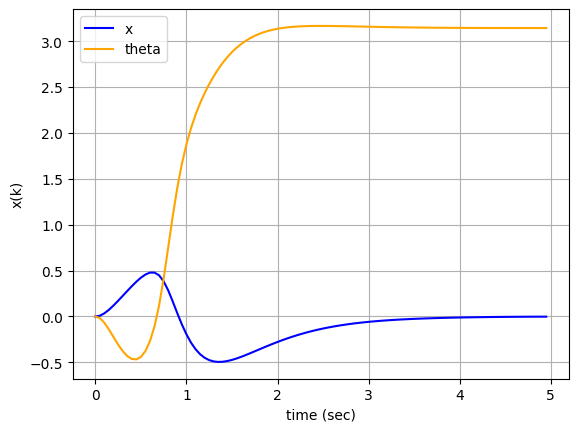

In [59]:
plot_x()

รูปที่ 5.6 แนววิถีสถานะเหมาะที่สุดของคาร์ทโพลจากอัลกอริทึม DDP

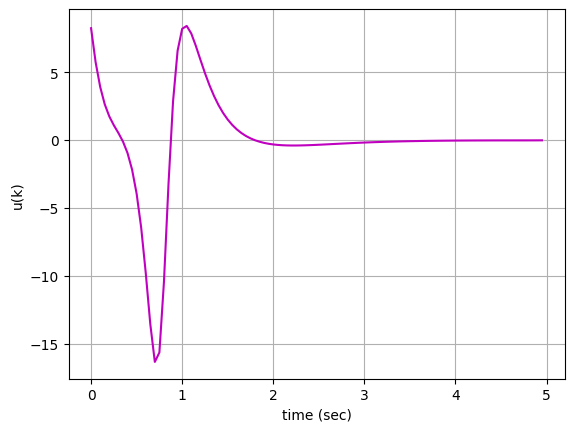

In [60]:
plot_u()

รูปที่ 5.7 แนววิถีตัวควบคุมเหมาะที่สุดของคาร์ทโพลจากอัลกอริทึม DDP

เราสามารถจำลองการเคลื่อนที่ของคาร์ทโพลอย่างง่ายบน meshcat โดยวิธีเหมือนกับในตัวอย่าง 5.1 
โดยสร้างโมเดลคาร์ทโพลดังในรูปที่ 5.8

<img src="https://raw.githubusercontent.com/dewdotninja/ocrl/refs/heads/main/doc/figs/ch5_cartpole_meshcat.png" width=400 />

รูปที่ 5.8 โมเดลจำลองคาร์ทโพลบน meshcat

In [61]:
import meshcat
import meshcat.geometry as geo
import meshcat.transformations as tf
#from meshcat.animation import Animation
import time

In [62]:
vis = meshcat.Visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [63]:
# create cartpole
def build_cartpole(vis):
    cart_pole = vis["cart_pole"]
    cart_pole.delete()
    cart = cart_pole["cart"]
    pivot = cart["pivot"]
    pole = pivot["pole"]
    pendulum = pole["pendulum"]
    cart.set_object(geo.Box([0.5, 0.3, 0.2]))
    pole.set_object(geo.Box([0.05, 0.05, 0.5]))
    pendulum.set_object(geo.Sphere(0.06))
    pole.set_transform(tf.translation_matrix([0, 0, -0.25]))
    pendulum.set_transform(tf.translation_matrix([0.0,0.0,-0.25]))
    # pivot.set_transform(tf.rotation_matrix(-np.pi/2, [0, 1, 0]))
    return cart,pivot

# update cartpole pose
def update_cartpole(x,th):
    cart_th.set_transform(tf.rotation_matrix(th,[0,1,0]))
    cart_x.set_transform(tf.translation_matrix([x, 0, 0]))

def simulate_cartpole():
    for k in range(xtraj.shape[1]):
        x = xtraj[0,k] # cart position
        th = xtraj[1,k] # pole angle
        update_cartpole(x,th)
        time.sleep(h)    


In [64]:
cart_x, cart_th = build_cartpole(vis)

In [66]:
simulate_cartpole()

<div align="center">
<img src="https://raw.githubusercontent.com/dewdotninja/sharing-github/refs/heads/master/dewninja_logo50.jpg" alt="dewninja"/>
</div>
<div align="center">dew.ninja 2025</div>